In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
learning_rate = 0.001

# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Given training indices, this function returns the training and pool data
def Get_data(X_pool, y_pool, Query_Size, X_train, y_train, training_indices):
    New_train_data=X_pool[training_indices,:]
    #New_train_data=New_train_data.reshape(-1,28*28).to(device, dtype=torch.float32)
    X_train=torch.cat((X_train,New_train_data),0)    
    New_train_targets=y_pool[training_indices]
    #Plot_PieChart(New_train_targets, 'PieChart_R', q+1)
    y_train=torch.cat((y_train,New_train_targets),0)
    mask = torch.ones(X_pool.shape[0], dtype=torch.bool)
    mask[training_indices] = False
    X_pool = X_pool[mask]
    y_pool = np.delete(y_pool, training_indices, axis=0)
    return X_pool, y_pool, X_train, y_train 

In [4]:
# Sampling methods
def LeastConfident(X_pool, y_pool, Query_Size, X_train, y_train):
    #X_pool=X_pool.reshape(-1,28*28).to(device, dtype=torch.float32)
    outputs= model(X_pool)
    #value, predicted = torch.max(outputs.data, 1)
    prob = F.softmax(outputs,dim=1)    
    uncertainties = prob.max(1)[0]
    training_indices=uncertainties.sort()[1][:Query_Size]
    return Get_data(X_pool, y_pool, Query_Size, X_train, y_train, training_indices)

def RandomSampling(X_pool, y_pool, Query_Size, X_train, y_train):
    new_samples=X_pool.shape[0]
    RandPer=torch.randperm(new_samples)
    training_indices = RandPer[0:Query_Size]
    return Get_data(X_pool, y_pool, Query_Size, X_train, y_train, training_indices)

# Least margin sampling method
def LeastMargin(X_pool, y_pool, Query_Size, X_train, y_train):
    #X_pool=X_pool.reshape(-1,28*28).to(device, dtype=torch.float32)
    outputs = model(X_pool)
    #value, predicted = torch.max(outputs.data, 1)
    prob = F.softmax(outputs,dim=1)
    probs_sorted, idxs = prob.sort(descending=True)
    uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]
    training_indices=uncertainties.sort()[1][:Query_Size] # [1] return only inicies
    return Get_data(X_pool, y_pool, Query_Size, X_train, y_train, training_indices)

# Entropy sampling method
def EntropySampling(X_pool, y_pool, Query_Size, X_train, y_train):
    #X_pool=X_pool.reshape(-1,28*28).to(device, dtype=torch.float32)
    outputs = model(X_pool)
    probs = F.softmax(outputs,dim=1)    
    log_probs = torch.log(probs)
    uncertainties = (probs*log_probs).sum(1)  
    training_indices=uncertainties.sort()[1][:Query_Size]
    return Get_data(X_pool, y_pool, Query_Size, X_train, y_train, training_indices)

In [5]:
# prepare training data
per_init_labeled=0.05 # percentage of labeled points
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
training_data, training_targets= train_dataset.data, train_dataset.targets
n_samples=training_data.shape[0]
training_indices= np.random.choice(n_samples, math.ceil(per_init_labeled*n_samples), replace=False)
# select the initial labeled data (size=args.per_init_labeled*n_samples)
X_train = training_data[training_indices].reshape(-1,28*28)
training_targets = np.array(training_targets)
y_train = training_targets[training_indices]
mask = torch.ones(training_data.shape[0], dtype=torch.bool)
mask[training_indices] = False # mark all selected data (i.e., labeled data)
#x_train_adjusted=torch.tensor(X_train)
x_train_adjusted=X_train.clone().detach()
y_train=torch.tensor(y_train).to(torch.long)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [6]:
# Prepare pool data (i.e., the rest of the data, which are unlabeled)
X_pool = training_data[mask].reshape(-1,28*28)
#X_pool=torch.tensor(X_pool)
X_pool=X_pool.clone().detach()
y_pool = training_targets[mask]
y_pool = torch.tensor(y_pool).to(torch.long)
X_pool=X_pool.to(torch.float32)
X_pool=X_pool.to(device)
y_pool=y_pool.to(device)

In [8]:
# prepare test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
testing_data, testing_targets= test_dataset.data, test_dataset.targets
n_test_samples=testing_data.shape[0]
testing_targets = np.array(testing_targets)
x_test_adjusted=testing_data.reshape([-1,28*28])
x_test_adjusted=x_test_adjusted.clone().detach()
y_test=torch.tensor(testing_targets).to(torch.long)

In [9]:
# the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
       
    def forward(self, x):
        # -> n, 3, 32, 32
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)
        #return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))

In [10]:
# first training
num_epochs = 5
for epoch in range(num_epochs):
    # origin shape: [4, 3, 32, 32] = 4, 3, 1024
    x_train_adjusted=x_train_adjusted.to(torch.float32)
    x_train_adjusted=x_train_adjusted.to(device)
    y_train=y_train.to(device)
    outputs = model(x_train_adjusted)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

12.609386444091797
12.382770538330078
8.381644248962402
5.7726922035217285
4.298091888427734


In [11]:
# calculate the accuracy of the trained model with the test data
with torch.no_grad():
    n_correct = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    x_test_adjusted=x_test_adjusted.to(torch.float32)
    x_test_adjusted=x_test_adjusted.to(device)
    outputs = model(x_test_adjusted)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples_test = x_test_adjusted.size(0)
    n_correct += (predicted == y_test).sum().item()
    for i in range(n_samples_test):
        label = y_test[i]
        pred = predicted[i]
        if (label == pred):
            n_class_correct[label] += 1
        n_class_samples[label] += 1       

    acc = 100.0 * n_correct / n_samples_test
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of class {classes[i]}: {acc} %')

Accuracy of the network: 42.02 %
Accuracy of class 0: 51.93877551020408 %
Accuracy of class 1: 30.484581497797357 %
Accuracy of class 2: 0.29069767441860467 %
Accuracy of class 3: 77.32673267326733 %
Accuracy of class 4: 88.4928716904277 %
Accuracy of class 5: 43.04932735426009 %
Accuracy of class 6: 50.0 %
Accuracy of class 7: 57.00389105058366 %
Accuracy of class 8: 20.636550308008214 %
Accuracy of class 9: 4.360753221010902 %


In [12]:
# in a loop, the active leraner selects the most uncertain point 
query_budget=np.int16(0.5*n_samples)
Query_rounds=20
Query_Size=np.int16(query_budget/Query_rounds)
Sampling_method=3
acc=np.zeros(Query_rounds+1)
epochs_no=10

In [66]:
for q in range(Query_rounds): 
    if Sampling_method==0:
        X_pool, y_pool, x_train_adjusted, y_train= RandomSampling(X_pool,y_pool, Query_Size, x_train_adjusted, y_train)
    elif Sampling_method==1:
        X_pool, y_pool, x_train_adjusted, y_train= LeastConfident(X_pool,y_pool, Query_Size, x_train_adjusted, y_train)
    elif Sampling_method==2:
        X_pool, y_pool, x_train_adjusted, y_train= LeastMargin(X_pool,y_pool, Query_Size, x_train_adjusted, y_train)
    else:
        X_pool, y_pool, x_train_adjusted, y_train= EntropySampling(X_pool, y_pool, Query_Size, x_train_adjusted, y_train)
    
    #n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        x_train_adjusted=x_train_adjusted.to(torch.float32)
        x_train_adjusted=x_train_adjusted.to(device)
        y_train=y_train.to(device)
        outputs = model(x_train_adjusted)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss.item())

    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        n_correct = 0
        #test_data=test_data.reshape(-1,28*28).to(device, dtype=torch.float32)
        outputs = model(x_test_adjusted)
        value, predicted = torch.max(outputs.data, 1)
        n_correct = (predicted == y_test).sum().item()
        acc[q+1] = 100.0 * n_correct / y_test.shape[0]
        print(f'Accuracy of the testing data on the {x_train_adjusted.shape[0]:} training images: {acc[q+1]} %')       
        if q==(Query_rounds-1):
            n_class_correct = [0 for i in range(10)]
            n_class_samples = [0 for i in range(10)]
            for i in range(n_samples_test):
                label = y_test[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1       

    #acc = 100.0 * n_correct / n_samples_test
    #print(f'Accuracy of the network: {acc} %')

Accuracy of the testing data on the 4500 training images: 69.29 %
Accuracy of the testing data on the 6000 training images: 83.53 %
Accuracy of the testing data on the 7500 training images: 85.0 %
Accuracy of the testing data on the 9000 training images: 88.4 %
Accuracy of the testing data on the 10500 training images: 90.57 %
Accuracy of the testing data on the 12000 training images: 91.87 %
Accuracy of the testing data on the 13500 training images: 92.46 %
Accuracy of the testing data on the 15000 training images: 93.39 %
Accuracy of the testing data on the 16500 training images: 93.8 %
Accuracy of the testing data on the 18000 training images: 94.1 %
Accuracy of the testing data on the 19500 training images: 94.37 %
Accuracy of the testing data on the 21000 training images: 94.76 %
Accuracy of the testing data on the 22500 training images: 94.92 %
Accuracy of the testing data on the 24000 training images: 95.15 %
Accuracy of the testing data on the 25500 training images: 95.36 %
Acc

Accuracy of the class 1 is: 97.95918367346938
Accuracy of the class 2 is: 98.41409691629956
Accuracy of the class 3 is: 95.15503875968992
Accuracy of the class 4 is: 95.44554455445545
Accuracy of the class 5 is: 95.82484725050917
Accuracy of the class 6 is: 95.17937219730942
Accuracy of the class 7 is: 96.45093945720251
Accuracy of the class 8 is: 96.69260700389106
Accuracy of the class 9 is: 94.55852156057495
Accuracy of the class 10 is: 94.05351833498513
number of labeled points of the class 1 is: 2016 isnatances out of 5923
number of labeled points of the class 2 is: 3539 isnatances out of 6742
number of labeled points of the class 3 is: 2724 isnatances out of 5958
number of labeled points of the class 4 is: 3496 isnatances out of 6131
number of labeled points of the class 5 is: 3292 isnatances out of 5842
number of labeled points of the class 6 is: 3249 isnatances out of 5421
number of labeled points of the class 7 is: 2299 isnatances out of 5918
number of labeled points of the cla

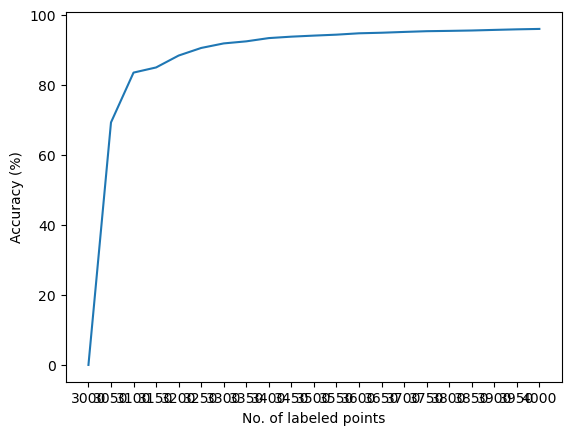

In [67]:
for i in range(10):    
    print('Accuracy of the class ' + str(i+1) + ' is: ' + str(100*np.array(n_class_correct[i])/np.array(n_class_samples[i])) )

for i in range(10):    
    print('number of labeled points of the class ' + str(i+1) + ' is: ' + str(np.sum(np.int16(np.array(y_train)==i))) + ' isnatances out of ' + str(np.sum(np.int16(np.array(training_targets)==i))))

Labels=[]
for k in range(q+2):    
    Labels.append(str(3000+k*50))
plt.plot(Labels, acc)
plt.ylabel('Accuracy (%)')
plt.xlabel('No. of labeled points')
# plt.savefig('RandomSampling.png')
# plt.savefig('RandomSampling.svg')
plt.show()